In [33]:
import os

import pandas as pd
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms
from torchvision.models import resnet18

from PIL import Image
import PIL
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

## подготовка датасетов

In [34]:
class MyTransform(object):
    def __call__(self, img):
        if img.shape[0] == 1:
            return torch.cat([img, img, img], dim=0)
        return  img

In [35]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    MyTransform(),
    transforms.RandomHorizontalFlip(),
    # transforms.ColorJitter(brightness=.3, hue=.05),
    # transforms.GaussianBlur(kernel_size=(2, 3), sigma=(0.1, 1)),
    # transforms.RandomRotation(degrees=10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

inv_normalize = transforms.Compose(
    [
        transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]),
        torchvision.transforms.ToPILImage()
    ]
)


valid_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225]),
])

In [36]:
from  torchvision.datasets import Caltech256

In [37]:
# main_dataset = ImageFolder("dataset", train_transform)
main_dataset = Caltech256("./", train_transform)
len(main_dataset)

30607

In [38]:
len(main_dataset.categories)

257

In [39]:
# train_ds, val_ds, _ = random_split(main_dataset, [22000, 2228, 0], generator=torch.Generator().manual_seed(42))
train_ds, val_ds, _ = random_split(main_dataset, [28000, 30607-28000, 0], generator=torch.Generator().manual_seed(42))

In [40]:
def tensor_to_image(image):
    return inv_normalize(image)

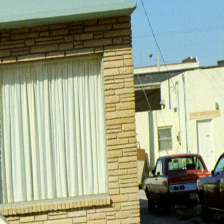

In [41]:
tensor_to_image(val_ds[10][0])

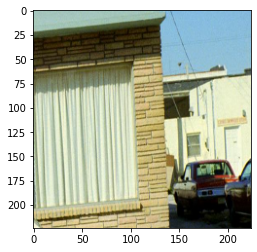

In [42]:
plt.imshow(tensor_to_image(val_ds[10][0]))

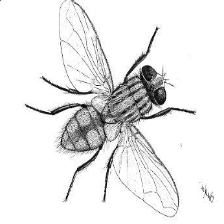

In [43]:
inv_normalize(val_ds[283][0])

In [44]:
# TRAIN_DIR = Path('dataset/enface')
# TEST_DIR = Path('dataset/profile')
#
# train_val_files = sorted(list(TRAIN_DIR.rglob('*.png')))
# test_files = sorted(list(TEST_DIR.rglob('*.png')))
#
# train_val_labels = [path.parent.name for path in train_val_files]
# train_files, val_files = train_test_split(train_val_files, test_size=0.25,
#                                           stratify=train_val_labels)

In [45]:
BATCH_SIZE = 16
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

In [46]:
next(iter(train_loader))[0].shape

torch.Size([16, 3, 224, 224])

## создаем модель

In [47]:
# !pip install timm

## обучение

In [48]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]

    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [49]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader, NUM_EPOCH=15):
    train_loss_log = []
    val_loss_log = []

    train_acc_log = []
    val_acc_log = []

    for epoch in tqdm(range(NUM_EPOCH),  position=0, leave=True):
        model.train()
        train_loss = 0.
        train_size = 0

        train_pred = 0.

        for imgs, labels in tqdm(train_dataloader, position=0, leave=True):
            optimizer.zero_grad()
            imgs = imgs.cuda()
            labels = labels.cuda()

            y_pred = model(imgs)

            loss = criterion(y_pred, labels)
            loss.backward()

            train_loss += loss.cpu().item()
            train_size += y_pred.size(0)
            train_loss_log.append(loss.data.cpu() / y_pred.size(0))

            train_pred += (y_pred.argmax(1) == labels).sum()

            optimizer.step()

        train_acc_log.append(train_pred / train_size)

        val_loss = 0.
        val_size = 0

        val_pred = 0.

        model.eval()

        with torch.no_grad():
            for imgs, labels in test_dataloader:

                imgs = imgs.cuda()
                labels = labels.cuda()

                pred = model(imgs)
                loss = criterion(pred, labels)

                val_loss += loss.cpu().item()
                val_size += pred.size(0)

                val_pred += (pred.argmax(1) == labels).sum()

        val_loss_log.append(val_loss / val_size)
        val_acc_log.append(val_pred / val_size)

        clear_output()
        plot_history(train_loss_log, val_loss_log, 'loss')

        print('Train loss:', (train_loss / train_size)*100)
        print('Val loss:', (val_loss / val_size)*100)
        print('Train acc:', (train_pred / train_size)*100)
        print('Val acc:', (val_pred / val_size)*100)

    return train_loss_log, train_acc_log, \
           val_loss_log, val_acc_log

In [50]:
import timm
model_names = timm.list_models("l2")
model_names

[]

In [95]:

model = timm.create_model("efficientnet_b2", pretrained=True)
model.classifier = nn.Sequential(nn.Linear(1408, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, 257))
# nn.Linear(1408, 257)


In [96]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

In [90]:
# from torchvision.models import efficientnet_v2_m
# from torchvision.models import EfficientNet_V2_M_Weights
#
# model = efficientnet_v2_m(EfficientNet_V2_M_Weights.IMAGENET1K_V1)
# model.classifier = nn.Linear(1280, 257)

In [97]:
model.conv_stem.requires_grad_(False)
model.bn1.requires_grad_(False)
model.act1.requires_grad_(False)
model.blocks.requires_grad_(False)
model.conv_head.requires_grad_(False)
model.bn2.requires_grad_(False)
model.act2.requires_grad_(False)
model.global_pool.requires_grad_(False)


SelectAdaptivePool2d (pool_type=avg, flatten=Flatten(start_dim=1, end_dim=-1))

In [98]:
model

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
   

In [99]:
for p in list(model.parameters())[:-6]:
    p.requires_grad_(False)

In [101]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

params

1115905

In [102]:
# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
# [p.size() for p in model_parameters]


In [103]:
model = model.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

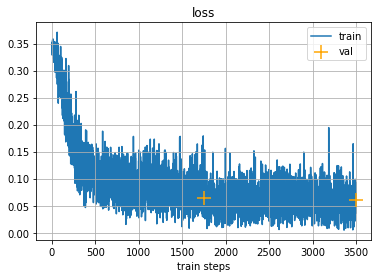

 67%|██████▋   | 2/3 [06:42<03:21, 201.62s/it]

Train loss: 5.850465535159622
Val loss: 6.085586641019544
Train acc: tensor(76.4643, device='cuda:0')
Val acc: tensor(77.2535, device='cuda:0')


 67%|██████▋   | 2/3 [07:06<03:33, 213.07s/it]


KeyboardInterrupt: 

In [104]:
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(model,
                                                                 criterion,
                                                                 optimizer,
                                                                 train_loader,
                                                                 valid_loader,
                                                                 3)

- sgd ([-2:], [-5:]), lr=0.001, acc=94
- adam, ([-5:]), lr=0.001, acc=98.51
- adam, ([-15:]), lr=0.001, acc=99.46
- b3, adam, ([-15:]), lr=0.001, acc=99.06
- b0, adam (all model), lr=0.001, acc=99.87 - 34 minutes

на новом датасете
- adam, b0 ([:-7]),lr=0.001,  acc=76.75
- adam, b0 ([all]),lr=0.001,  acc=62, 68
- adam, b0 ([:-3]),lr=0.001,  acc=76.94, 79.44
- adam, b2, ([:-2] - clf only), lr=0.001 acc=79.51, 80.01, 83.01
- adam, b2, ([:-2] + big clf only), lr=0.001 acc=75.51, 79.01
- adam, b_v2_m,([:-2] - clf only) lr=0.001,    acc = 73.1б 75.37
- adam, b_v2_m ([:8]) lr=0.001 acc=77.52
-

## выполняем предсказания

In [26]:
import pandas as pd

In [27]:
df = pd.read_csv("sample_submission.csv")
df.head()

,filename,label
0,1.png,1
1,2.png,1
2,3.png,1
3,5.png,1
4,6.png,1


In [49]:
sub_filenames = df.filename.values
res = dict()

In [50]:
for filename in tqdm(sub_filenames):
    img = Image.open(f"./test/ {filename}")
    img = torch.unsqueeze(valid_transform(img), 0).to("cuda")
    tmp = model(img)
    label = tmp.argmax()
    res[filename] = label

100%|██████████| 11514/11514 [04:57<00:00, 38.66it/s]


In [54]:
df

,filename,label
0,1.png,1
1,2.png,1
2,3.png,1
3,5.png,1
4,6.png,1
...,...,...
11509,11578.png,1
11510,11579.png,1
11511,11580.png,1
11512,11581.png,1


In [55]:
df.label = df.filename.apply(lambda x: res[x].cpu().item())

In [56]:
df

,filename,label
0,1.png,0
1,2.png,0
2,3.png,0
3,5.png,1
4,6.png,0
...,...,...
11509,11578.png,1
11510,11579.png,0
11511,11580.png,0
11512,11581.png,0


In [57]:
df.to_csv("syb_1.csv", index=False)